In [1]:
# imports
import pathlib
import numpy as np, matplotlib.pyplot as plt, pandas as pd
from PIL import Image
from scipy import optimize
from skimage import draw
from flyeranalysis.flyer_detection import Flyer_Detection

In [2]:
# constants
example_im_path = (
    pathlib.Path(".").resolve().parent.parent
    / "flyer_image_examples"
    / "20220923"
    / "HS--20220923--00002"
    / "BMP"
    / "Camera_11_30_10"
    / "Camera_11_30_10_125.bmp"
)

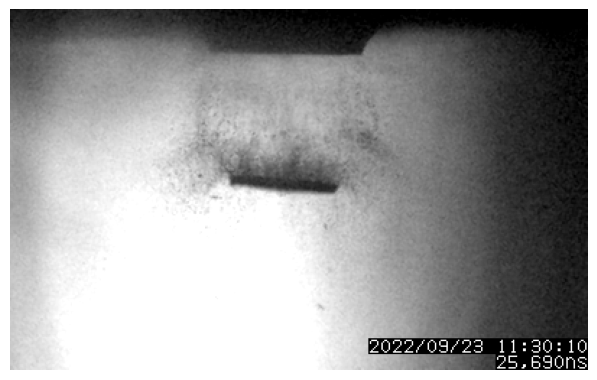

In [3]:
# original image
example_im_arr = np.asarray(Image.open(example_im_path))
f,ax = plt.subplots(figsize=(7.5,7.5*example_im_arr.shape[0]/example_im_arr.shape[1]))
ax.imshow(example_im_arr,cmap="gray")
ax.axis("off")
plt.show()

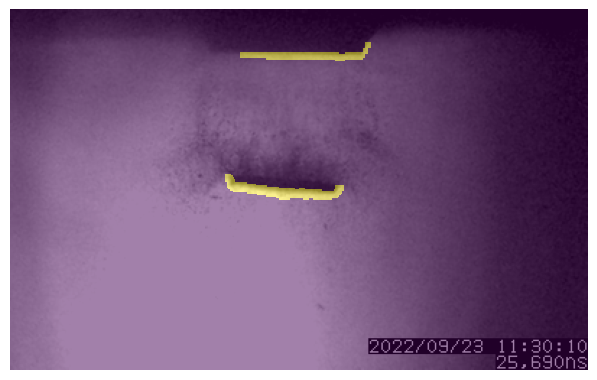

In [4]:
# Gaussian filtering, edge detection, thresholding, morphology transformations, and cropping
analyzer = Flyer_Detection()
filtered_image = np.zeros_like(example_im_arr)
filtered_cropped_image = analyzer.filter_image(example_im_arr)
filtered_image[:filtered_cropped_image.shape[0],:filtered_cropped_image.shape[1]] = filtered_cropped_image
f,ax = plt.subplots(figsize=(7.5,7.5*example_im_arr.shape[0]/example_im_arr.shape[1]))
ax.imshow(example_im_arr,cmap="gray")
ax.imshow(filtered_image,alpha=0.5,interpolation="nearest")
ax.axis("off")
plt.show()

In [5]:
img = filtered_cropped_image
#Find the points where the threshold has identified the flyer points
x,y=np.where(img==255)
max_x=max(x)
#I'm creating a dataframe here so that have I can find the lowest column, and isolating those points alone
df=pd.DataFrame(zip(y,x),columns=['y','x'])
df=df[df['x']>=max_x-30]
df=df.sort_values(by=['y','x']).reset_index(drop=True)
df=df.groupby('y').max().reset_index()
#I then find the lowest x point, and get 60% of the flyer
df=df.sort_values(by=['x']).reset_index(drop=True)
x=np.array(df['x'])
y=np.array(df['y'])
max_y=np.amax(y)
min_y=np.amin(y)
t=int(np.ceil((max_y-min_y)*0.3))
print(f"max_y = {max_y}, min_y = {min_y}, t = {t}, y[-1] = {y[-1]}")
t1=y[-1]-t
t2=y[-1]+t
print(f'initial t1 = {t1}, t2= {t2}')
#Here, I am making sure to check corner points, and ensure that if +/- 0.3 is more on one side, the difference is transferred to the other side instead
if t1<min_y:
  if (t1-min_y+t2)<=max_y:
    t2+=(t1-min_y) 
  else: 
    t2=max_y
if t2>max_y:
  if (t1-(t2-max_y))>=min_y:
    t1-=(t2-max_y) 
  else: 
    t2=min_y
print(f'adjusted t1 = {t1}, t2= {t2}')
#Finding the slope of the 
#I'm reconstucting the flyer image here, for better understandability. This will not affect the radius of curvature but will help in drawing the disk!
img2=np.zeros((img.shape[0],img.shape[1]))
img2[x,y]=255

max_y = 230, min_y = 149, t = 25, y[-1] = 189
initial t1 = 164, t2= 214
adjusted t1 = 164, t2= 214


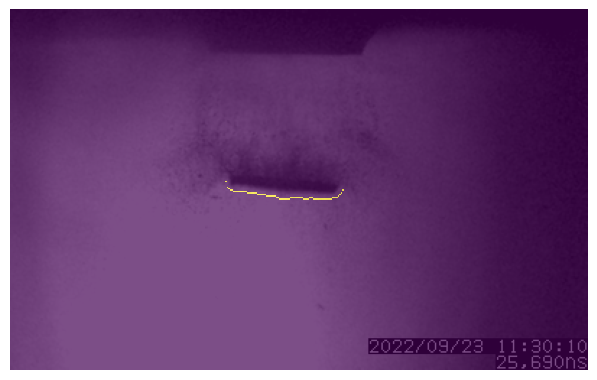

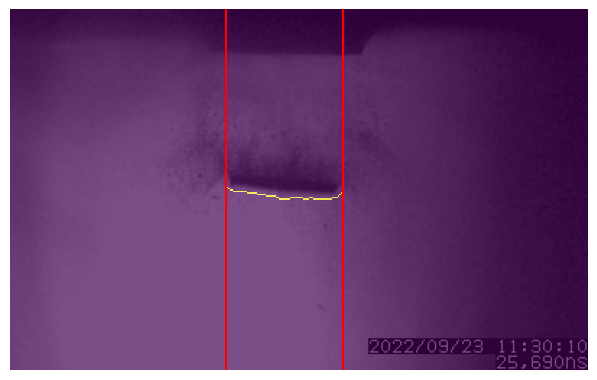

In [6]:
# selecting only the middle 60% of the bottom edge of the flyer
bottom_edge_img = np.zeros_like(example_im_arr)
bottom_edge_img[:img2.shape[0],:img2.shape[1]] = img2

f,ax = plt.subplots(figsize=(7.5,7.5*example_im_arr.shape[0]/example_im_arr.shape[1]))
ax.imshow(example_im_arr,cmap="gray")
ax.imshow(bottom_edge_img,alpha=0.7,interpolation="nearest")
ax.axis("off")
plt.show()

f,ax = plt.subplots(figsize=(7.5,7.5*example_im_arr.shape[0]/example_im_arr.shape[1]))
ax.imshow(example_im_arr,cmap="gray")
ax.imshow(bottom_edge_img,alpha=0.7,interpolation="nearest")
ax.axvline(min_y,color="r")
ax.axvline(max_y,color="r")
ax.axis("off")
plt.show()

fit_midpoint = y[-1]

#f,ax = plt.subplots(figsize=(7.5,7.5*example_im_arr.shape[0]/example_im_arr.shape[1]))
#ax.imshow(example_im_arr,cmap="gray")
#ax.imshow(bottom_edge_img,alpha=0.7,interpolation="nearest")
#ax.axvline(y[-1],color="b")
#ax.axvline(t1,color="r")
#ax.axvline(t2,color="r")
#ax.axis("off")
#plt.show()

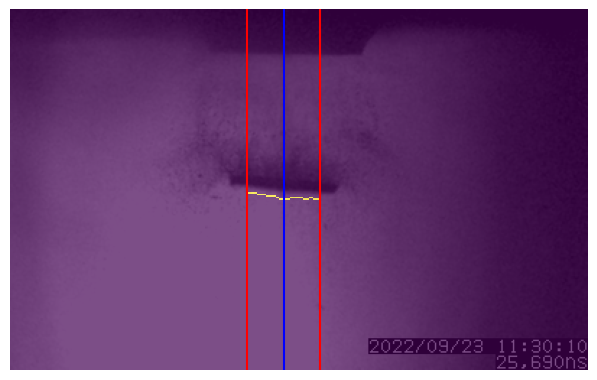

In [7]:
d=img2[:,t1:t2]
a1=np.zeros((img.shape[0],t1))
a2=np.zeros((img.shape[0],img.shape[1]-t2))
temp=np.concatenate((a1,d,a2),axis=1)
x,y=np.nonzero(temp)
img3=np.zeros((img.shape[0],img.shape[1]))
img3[x,y]=255

fit_edge_img = np.zeros_like(example_im_arr)
fit_edge_img[:img3.shape[0],:img3.shape[1]] = img3

f,ax = plt.subplots(figsize=(7.5,7.5*example_im_arr.shape[0]/example_im_arr.shape[1]))
ax.imshow(example_im_arr,cmap="gray")
ax.imshow(fit_edge_img,alpha=0.7,interpolation="nearest")
ax.axvline(fit_midpoint,color="b")
ax.axvline(t1,color="r")
ax.axvline(t2,color="r")
ax.axis("off")
plt.show()

In [8]:
df=pd.DataFrame(zip(y,x),columns=['y','x'])
df=df.sort_values(by=['y']).reset_index(drop=True)
#Using the Least Squares method with Levenberg-Marquardt Optimization (which is Dampened Least Squares similar to L2 regularization)
x_m = np.mean(x)
y_m = np.mean(y)
u= x - x_m
v = y - y_m
method_2 = "leastsq"
#Coope's method can be implemented here to linearize the equation, but I am unsure if that can be used with L-M which is a non-linear method
#I have written down the equation in the comments the starting point for Coope's method.
#Code for the least squares 
def calc_R(xc, yc):
  #2 Xc X + 2 Yc Y + R² - Xc² - Yc² = X² + Y²
  return np.sqrt((x-xc)**2 + (y-yc)**2)
def f_2(c):
  Ri = calc_R(*c)
  return Ri - Ri.mean()
#Using Scipy's Least Squares Optimization method to find the center of the circle
center_estimate = x_m,y_m
print(f"center_estimate = {center_estimate}")
center_2 = optimize.least_squares(f_2, center_estimate, method='lm')
xc_2, yc_2 = center_2.x
print(f"Fitted center = ({xc_2}, {yc_2})")
#Calculating the radius of the circle
Ri_2       = calc_R(*center_2.x)
R_2        = Ri_2.mean()
#Finding the tilt using arctan and slope value. For a circle, the slope is: -(x-xc)/(y-yc)
h,v=df.iloc[int(np.ceil(len(df)/2))]
tilt=np.arctan((v-yc_2)/(h-xc_2))
print(f"h = {h} (median y = {np.median(y)}), v = {v} (median x = {np.median(x)}), tilt = {tilt}")
# rr, cc = draw.disk((xc_2, yc_2), R_2, shape=temp.shape)
# fc.analysis_image=copy.deepcopy(img2) 
# fc.analysis_image[rr, cc] = 100
# x,y=np.nonzero(temp)
# fc.analysis_image[x, y] = 256
# fc.analysis_image=(fc.analysis_image-np.min(fc.analysis_image))/(np.max(fc.analysis_image)-np.min(fc.analysis_image))
# fc.analysis_image = 255 * fc.analysis_image # Now scale by 255
# fc.analysis_image= fc.analysis_image.astype(np.uint8)

center_estimate = (129.52, 188.5)
Fitted center = (-49.28611057839992, 203.15802410588648)
h = 189 (median y = 188.5), v = 131 (median x = 130.0), tilt = -0.29404279969804953
